In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Import custom functions (assuming these are in your path as in the original code)
# Replace with your actual path as needed
import sys
sys.path.insert(0, '/Users/xiaohan/Working/Ning/Giles1/Code/Python_Implementation/scripts')

from eif import eif_cpi_empirical
from empirical_cdf import empirical_rf_pdf

In [2]:
# Set seed for reproducibility
seed = 2024
np.random.seed(seed)

# Load wine quality data
wine_data = pd.read_csv('/Users/xiaohan/Working/Ning/Giles1/Code/Python_Implementation/data/winequality-red.csv', delimiter=';')

# Display dataset information
print("Wine dataset shape:", wine_data.shape)
wine_data.head()

Wine dataset shape: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
# Convert quality to binary classification problem (quality > 5)
wine_data['quality'] = (wine_data['quality'] > 5).astype(int)

# Move 'quality' column to the first position
cnt = wine_data.pop('quality')
wine_data.insert(0, 'quality', cnt)

# Display the transformed data
print("Distribution of quality values:")
print(wine_data['quality'].value_counts())
wine_data.head()

Distribution of quality values:
quality
1    855
0    744
Name: count, dtype: int64


,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,0,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,0,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,1,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [4]:
# Get feature names (excluding the target variable 'quality')
features = wine_data.columns[1:].tolist()
print("Features to analyze:", features)

# Initialize results dictionary to store metrics for each dropped feature
results = {
    'dropped_feature': [],
    'naive_CPI': [],
    'plug_in_CPI': [],
    'tmle_final': [],
    'tmle_var': [],
    'ci_margin':[]
}

# Sample size for the empirical distributions
N = 500

Features to analyze: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [5]:
def calculate_feature_importance(full_data, feature_to_drop, N=500, seed=2024):
    """
    Calculate feature importance metrics (CPI) when dropping a specific feature.
    
    Parameters:
    -----------
    full_data : DataFrame
        The complete dataset with all features.
    feature_to_drop : str
        The feature to drop for importance calculation.
    N : int
        Sample size for empirical distributions.
    seed : int
        Random seed for reproducibility.
        
    Returns:
    --------
    dict
        Dictionary containing various CPI metrics.
    """
    # Create reduced dataset by dropping the specified feature
    reduced_data = full_data.drop([feature_to_drop], axis=1, inplace=False)
    
    # Fit full model using Random Forest
    full_model = RandomForestClassifier(n_estimators=500, max_features=1/3)
    full_model.fit(full_data.iloc[:, 1:], full_data["quality"])
    
    # Fit reduced model using Random Forest
    reduced_model = RandomForestClassifier(n_estimators=500, max_features=1/3)
    reduced_model.fit(reduced_data.iloc[:, 1:], reduced_data["quality"])
    
    # Fit Random Forest model for predicting the dropped feature
    reduced_model_x = RandomForestRegressor(n_estimators=500, max_features=1/3)
    reduced_model_x.fit(
        full_data.drop(["quality", feature_to_drop], axis=1, inplace=False), 
        full_data[feature_to_drop]
    )
    
    # Fit Random Forest model for predicting quality with reduced data
    reduced_model_y = RandomForestRegressor(n_estimators=500, max_features=1/3)
    reduced_model_y.fit(reduced_data.iloc[:, 1:], reduced_data["quality"])
    
    # Calculate empirical densities
    reduced_den_y = empirical_rf_pdf(
        forest=reduced_model_y, 
        X_train=reduced_data.iloc[:, 1:], 
        X_test=reduced_data.iloc[:, 1:], 
        seed=seed+2024
    )
    
    reduced_den_x = empirical_rf_pdf(
        forest=reduced_model_x, 
        X_train=full_data.drop(["quality", feature_to_drop], axis=1, inplace=False), 
        X_test=full_data.drop(["quality", feature_to_drop], axis=1, inplace=False), 
        seed=seed+2024
    )
    
    # Calculate initial EIF
    eif_now = eif_cpi_empirical(full_data, reduced_den_y, reduced_den_x, N, full_model, seed+2024)
    
    # Calculate naive CPI
    naive_CPI = np.mean(eif_now.iloc[:, 2])
    
    # Calculate plug-in CPI
    plug_in_CPI = np.mean(eif_now.iloc[:, 0] - eif_now.iloc[:, 1] + eif_now.iloc[:, 2])
    
    # Calculate EIF
    eif = eif_now.iloc[:, 0] - 2 * eif_now.iloc[:, 1] + eif_now.iloc[:, 2]
    
    # Prepare regression frame
    curr_offset = reduced_model.predict(full_data.drop(["quality", feature_to_drop], axis=1, inplace=False))
    regress_frame = pd.DataFrame({
        'y': full_data.iloc[:, 0],
        'curr_offset': curr_offset,
        'obs': eif
    })
    
    # Perform linear regression
    lm = LinearRegression(fit_intercept=False)
    lm.fit(regress_frame[['curr_offset', 'obs']], regress_frame['y'])
    epsilon_now = lm.coef_[1]
    next_offset = lm.predict(regress_frame[['curr_offset', 'obs']])
    
    # Update densities
    eif_scaled = eif * epsilon_now/100
    reduced_den_x_update = reduced_den_x + np.outer(eif_scaled, np.ones(reduced_den_x.shape[1]))
    reduced_den_x_update = np.maximum(reduced_den_x_update, 0)
    row_sums = reduced_den_x_update.sum(axis=1, keepdims=True)
    reduced_den_x_update = np.divide(reduced_den_x_update, row_sums, where=row_sums!=0)
    
    reduced_den_y_update = reduced_den_y + np.outer(eif_scaled, np.ones(reduced_den_y.shape[1]))
    reduced_den_y_update = np.maximum(reduced_den_y_update, 0)
    row_sums = reduced_den_y_update.sum(axis=1, keepdims=True)
    reduced_den_y_update = np.divide(reduced_den_y_update, row_sums, where=row_sums!=0)
    
    # Recalculate EIF for TMLE one-step
    eif_now = eif_cpi_empirical(full_data, reduced_den_y_update, reduced_den_x_update, N, full_model, seed+2024)
    tmle_onestep = np.mean(eif_now.iloc[:, 0] - eif_now.iloc[:, 1] + eif_now.iloc[:, 2])
    
    # Iterative process for TMLE
    tol = 1e-3
    epsilon = 1
    iteration = 0
    max_iterations = 50  # Add a maximum iteration count to prevent infinite loops
    
    while epsilon > tol and iteration < max_iterations:
        iteration += 1
        eif = eif_now.iloc[:, 0] - 2 * eif_now.iloc[:, 1] + eif_now.iloc[:, 2]
        regress_frame['obs'] = eif
        regress_frame['curr_offset'] = next_offset
        
        lm.fit(regress_frame[['curr_offset', 'obs']], regress_frame['y'])
        epsilon_now = lm.coef_[1]
        next_offset = lm.predict(regress_frame[['curr_offset', 'obs']])
        
        eif_scaled = eif * epsilon_now/100
        
        reduced_den_x_update = reduced_den_x + np.outer(eif_scaled, np.ones(reduced_den_x.shape[1]))
        reduced_den_x_update = np.maximum(reduced_den_x_update, 0)
        row_sums = reduced_den_x_update.sum(axis=1, keepdims=True)
        reduced_den_x_update = np.divide(reduced_den_x_update, row_sums, where=row_sums!=0)
        
        reduced_den_y_update = reduced_den_y + np.outer(eif_scaled, np.ones(reduced_den_y.shape[1]))
        reduced_den_y_update = np.maximum(reduced_den_y_update, 0)
        row_sums = reduced_den_y_update.sum(axis=1, keepdims=True)
        reduced_den_y_update = np.divide(reduced_den_y_update, row_sums, where=row_sums!=0)
        
        eif_now = eif_cpi_empirical(full_data, reduced_den_y_update, reduced_den_x_update, N, full_model, seed+2024)
        epsilon = abs(epsilon_now)
    
    # Calculate final TMLE
    tmle_final = np.mean(eif_now.iloc[:, 0] - eif_now.iloc[:, 1] + eif_now.iloc[:, 2])
    tmle_var = np.mean(
        (eif_now.iloc[:, 0] - eif_now.iloc[:, 1] + eif_now.iloc[:, 2] - tmle_final)**2)
    n_obs = len(full_data)
    ci_margin = 2 * np.sqrt(tmle_var / n_obs)
    
    return {
        'naive_CPI': naive_CPI,
        'plug_in_CPI': plug_in_CPI,
        'tmle_onestep': tmle_onestep,
        'tmle_final': tmle_final,
        'tmle_var': tmle_var,
        'ci_margin': ci_margin,
        'iterations': iteration
    }

In [6]:
# Loop through each feature and calculate importance metrics
for feature in features:
    print(f"Processing feature: {feature}")
    metrics = calculate_feature_importance(wine_data, feature, N, seed)
    
    results['dropped_feature'].append(feature)
    results['naive_CPI'].append(metrics['naive_CPI'])
    results['plug_in_CPI'].append(metrics['plug_in_CPI'])
    results['tmle_final'].append(metrics['tmle_final'])
    results['tmle_var'].append(metrics['tmle_var'])
    results['ci_margin'].append(metrics['ci_margin'])
    
    
    print(f"  Naive CPI: {metrics['naive_CPI']:.4f}")
    print(f"  Plug-in CPI: {metrics['plug_in_CPI']:.4f}")
    print(f"  TMLE Final: {metrics['tmle_final']:.4f}")
    print(f"  Iterations: {metrics['iterations']}")
    print("-" * 50)

Processing feature: fixed acidity
  Naive CPI: 0.0012
  Plug-in CPI: 0.0018
  TMLE Final: 0.0018
  Iterations: 1
--------------------------------------------------
Processing feature: volatile acidity
  Naive CPI: 0.0011
  Plug-in CPI: 0.0016
  TMLE Final: 0.0016
  Iterations: 1
--------------------------------------------------
Processing feature: citric acid
  Naive CPI: 0.0008
  Plug-in CPI: 0.0012
  TMLE Final: 0.0012
  Iterations: 1
--------------------------------------------------
Processing feature: residual sugar
  Naive CPI: 0.0014
  Plug-in CPI: 0.0019
  TMLE Final: 0.0019
  Iterations: 1
--------------------------------------------------
Processing feature: chlorides
  Naive CPI: 0.0012
  Plug-in CPI: 0.0017
  TMLE Final: 0.0017
  Iterations: 1
--------------------------------------------------
Processing feature: free sulfur dioxide
  Naive CPI: 0.0015
  Plug-in CPI: 0.0022
  TMLE Final: 0.0022
  Iterations: 1
--------------------------------------------------
Processing f

In [7]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort by TMLE for feature importance ranking
results_sorted = results_df.sort_values(by='tmle_final', ascending=False)

# Display sorted results
results_sorted

,dropped_feature,naive_CPI,plug_in_CPI,tmle_final,tmle_var,ci_margin
5,free sulfur dioxide,0.001481,0.002201,0.002201,0.000769,0.001387
6,total sulfur dioxide,0.001567,0.002199,0.002199,0.000727,0.001348
3,residual sugar,0.001352,0.001911,0.001911,0.000576,0.001201
0,fixed acidity,0.001227,0.001771,0.001771,0.000685,0.001309
4,chlorides,0.001208,0.001724,0.001724,0.000503,0.001121
9,sulphates,0.001245,0.001699,0.001699,0.000516,0.001136
10,alcohol,0.001335,0.001669,0.001669,0.000429,0.001036
1,volatile acidity,0.001131,0.001576,0.001576,0.000452,0.001063
7,density,0.000851,0.001253,0.001253,0.000357,0.000945
2,citric acid,0.000838,0.001206,0.001206,0.000353,0.000939


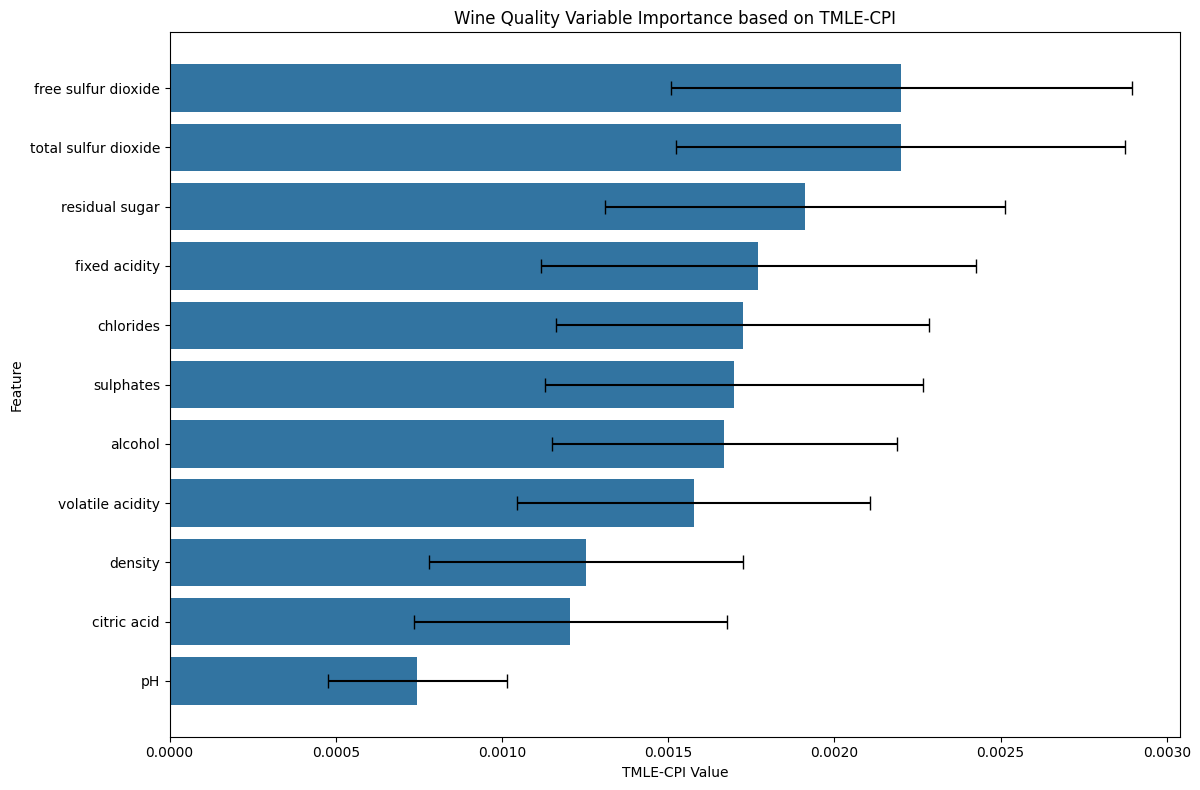

In [17]:
# Plot feature importance based on TMLE
plt.figure(figsize=(12, 8))
sns.barplot(x='tmle_final', y='dropped_feature', data=results_sorted)
plt.title('Wine Quality Variable Importance based on TMLE-CPI')
plt.xlabel('TMLE-CPI Value')
plt.ylabel('Feature')
plt.tight_layout()
# Add error bars to show confidence intervals
plt.errorbar(
    x=results_sorted['tmle_final'],
    y=range(len(results_sorted)),
    xerr=results_sorted['ci_margin']/2,
    fmt='none',
    ecolor='black',
    capsize=5
)
plt.show()